# Visualizing Optimization Algorithms

## 1. Intro

The task in this lab session is to implement a subset of the known optimization algorithms used in neural network training. 

Specifically, you are given a function ([The Beale Function](https://www.sfu.ca/~ssurjano/beale.html)) simulating the _loss_ space in which gradient descent with respect to the parameters needs to be performed. To simplify visualization, the function that models the loss space is defined over two parameters: $(x, y)$.

Your task is to implement a method to compute the gradient of the loss function with respect to its two parameters and then use the gradient vector to implement and analyze the behavior of the following optimization methods: **SGD**, **Momentum**, **Nesterov Gradient**, **Adagrad**, **Adadelta**, **RMSProp** and **Adam**.

### Imports

In [1]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
#from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

**Define Beale function**

In [30]:
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

**Define plot limits**

In [31]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

In [32]:
mesh_x, mesh_y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [33]:
mesh_z = beale(mesh_x, mesh_y)

Global  minimum of the Beale function is at $(3, 0.5)$

In [34]:
minimum = np.array([3, 0.5])
beale(*minimum)

0.0

Transpose minimum:

In [35]:
minimum_t = minimum.reshape(-1, 1)
print(minimum_t.shape)

beale(*minimum_t)

(2, 1)


array([0.])

### 3D Surface Plot of Beale Function

<IPython.core.display.Javascript object>


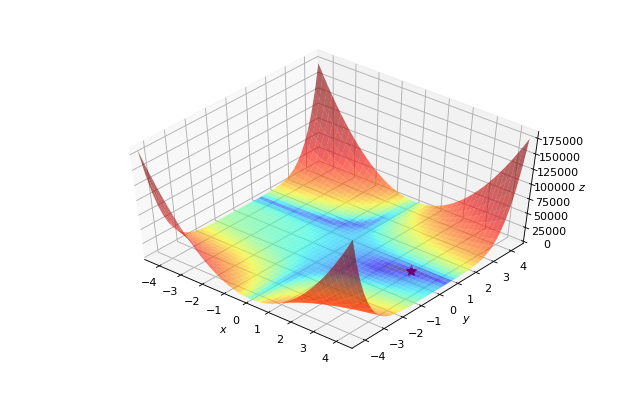

In [36]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(mesh_x, mesh_y, mesh_z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.6, cmap=plt.cm.jet)
ax.plot(*minimum_t, beale(*minimum_t), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

Let us plot the Gradient Vector Field. We use `autograd` to compute it and the Matplotlib `quiver` method to plot it.

In [37]:
dbeale_dx = elementwise_grad(beale, argnum=0)(mesh_x, mesh_y)
dbeale_dy = elementwise_grad(beale, argnum=1)(mesh_x, mesh_y)

<IPython.core.display.Javascript object>


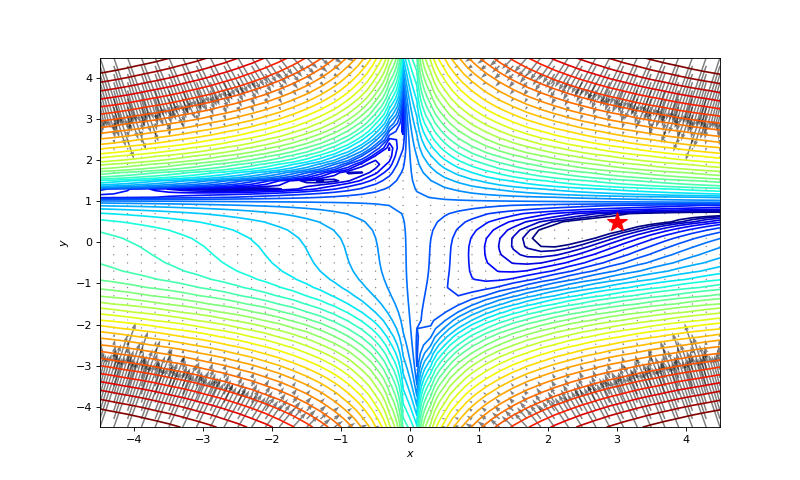

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(mesh_x, mesh_y, mesh_x - dbeale_dx, mesh_y - dbeale_dy, alpha=.5)
ax.plot(*minimum_t, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [29]:
def trace_path(optimization_sol):
    path = np.array(optimization_sol).T

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
    ax.plot(*minimum_t, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()

In [39]:
def view_update_history(updates):
    deltas = np.array(updates).T
    
    delta_x = deltas[0, :]
    delta_y = deltas[1, :]
    
    xx = np.arange(0, delta_x.shape[0])
    
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(xx, delta_x, 'o-')
    plt.title('Parameter update history')
    plt.ylabel('Updates to x direction')

    plt.subplot(2, 1, 2)
    plt.plot(xx, delta_y, 'o-')
    plt.xlabel('Update step')
    plt.ylabel('Updates to y direction')

    plt.show()

## 2. Optimization algorithms

We set the starting point as  $(1,1.75)$ , since it is challenging for algorithms with a little too much momentum in the gradient descent update rule, as they may overshoot and end up in some local minima.

In [40]:
start_tall = np.array([3., 4.])
start_med = np.array([1., 1.75])
start_low = np.array([1., 1.])

EPOCHS = 400

In [41]:
def grad_beale(x, y):
    df_dx = 2 * ((1.5 - x + x*y) * (y - 1) + (2.25 - x + x * y**2) * (y**2 - 1) + (2.625 - x + x * y**3) * (y**3 - 1))
    df_dy = 2 *((1.5 - x + x*y) * x + (2.25 - x + x * y**2) * 2 * x * y + (2.625 - x + x * y**3) * 3 * x * y**2)
    
    return df_dx, df_dy

In [42]:
def hessian_beale(x, y):
    raise NotImplementedError()

In [43]:
ref_dx = elementwise_grad(beale, argnum=0)(mesh_x, mesh_y)
ref_dy = elementwise_grad(beale, argnum=1)(mesh_x, mesh_y)

df_dx, df_dy = grad_beale(mesh_x, mesh_y)

np.testing.assert_array_almost_equal(ref_dx, df_dx, decimal = 6, verbose=True)
np.testing.assert_array_almost_equal(ref_dy, df_dy, decimal = 6, verbose=True)


**SGD**

In [44]:
def SGD_beale(start=start_med, target=minimum, lr=1e-3, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        dx, dy = grad_beale(*params)
        
        delta_params = lr * np.array([dx, dy])
        params = params - delta_params
        
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [45]:
sgd_sol, sgd_updates, sgd_diff = SGD_beale(start=start_med)

1.017168167327364


<IPython.core.display.Javascript object>


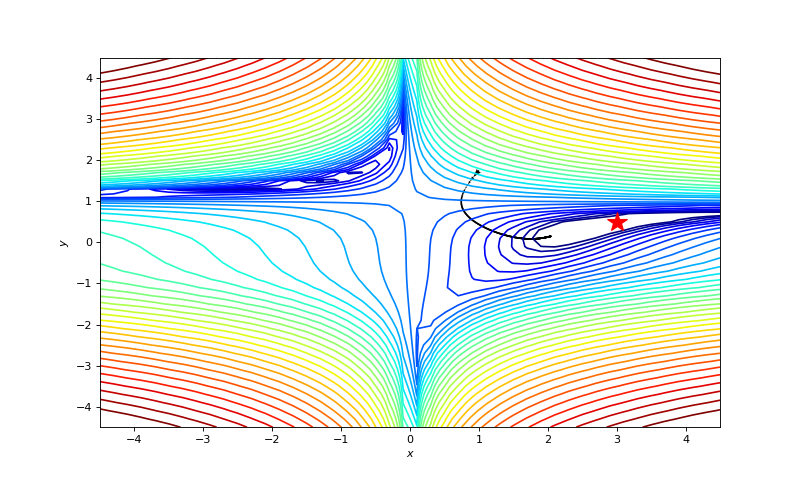

In [46]:
print(sgd_diff)
trace_path(sgd_sol)

<IPython.core.display.Javascript object>


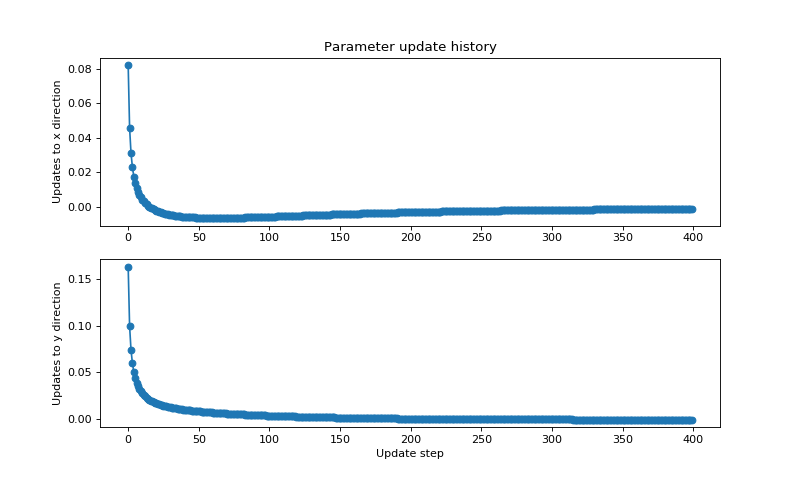

In [47]:
view_update_history(sgd_updates)

**Momentum**

In [48]:
def momentum_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, epochs=EPOCHS):
    delta_params = np.zeros(2)
    
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        dx, dy = grad_beale(*params)
        delta_params = gamma * delta_params + lr * np.array([dx, dy])
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [49]:
momentum_sol, momentum_updates, momentum_diff = momentum_beale(start=start_med)

0.13853887236394447


<IPython.core.display.Javascript object>


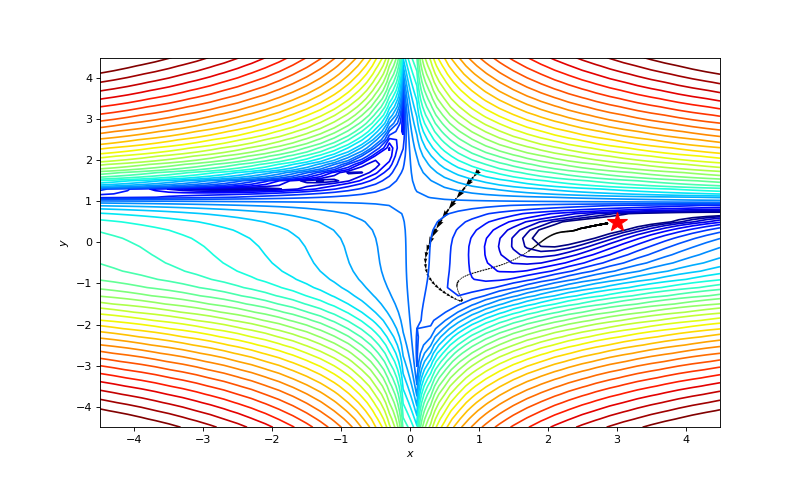

In [50]:
print(momentum_diff)
trace_path(momentum_sol)

<IPython.core.display.Javascript object>


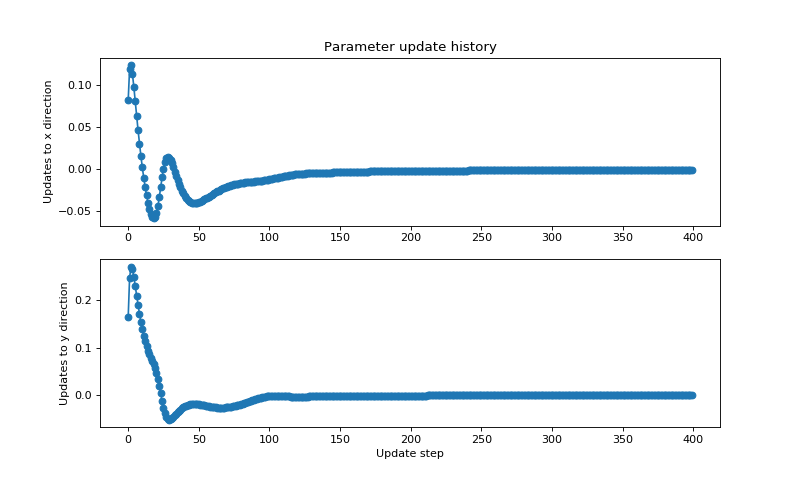

In [51]:
view_update_history(momentum_updates)

**Nesterov**

In [52]:
def nesterov_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, epochs=EPOCHS):
    delta_params = np.zeros(2)
    
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        p_foresight = params - gamma * delta_params
        dx, dy = grad_beale(*p_foresight)
        delta_params = gamma * delta_params + lr * np.array([dx, dy])
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [53]:
nesterov_sol, nesterov_updates, nesterov_diff = nesterov_beale(start=start_med)

0.13359752885046636


<IPython.core.display.Javascript object>


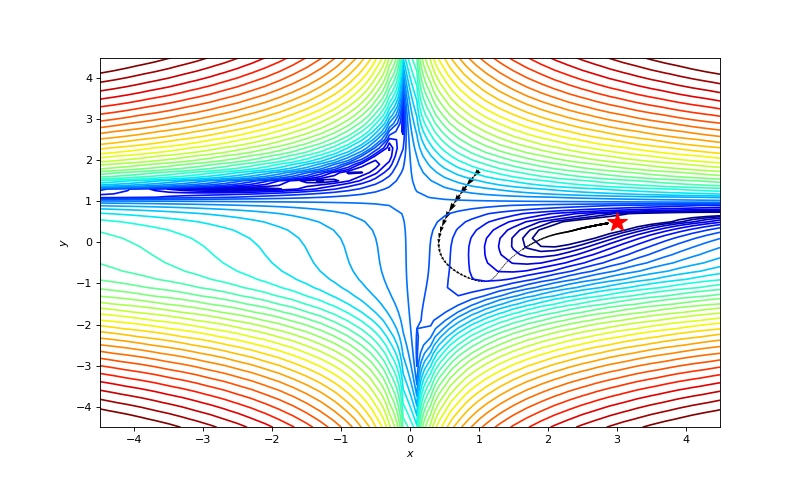

In [54]:
print(nesterov_diff)
trace_path(nesterov_sol)

<IPython.core.display.Javascript object>


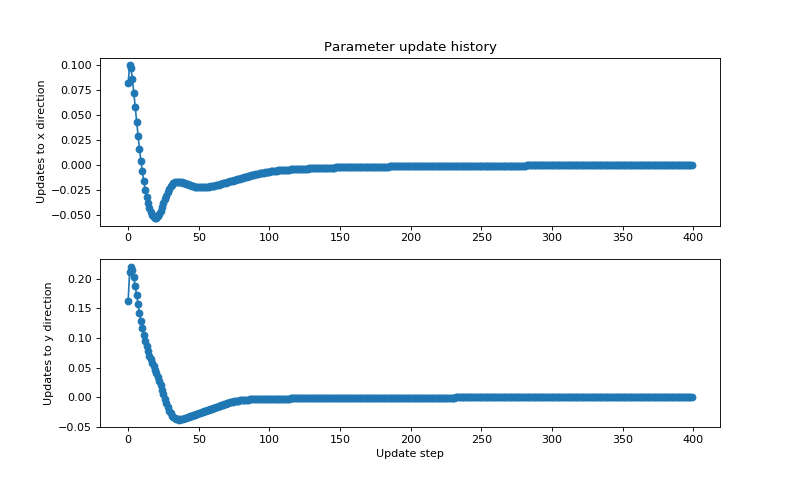

In [55]:
view_update_history(nesterov_updates)

**Adagrad**

In [56]:
def adagrad_beale(start=start_med, target=minimum, lr=1e-2, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    G = np.zeros((start.shape[0], start.shape[0]))
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        
        grad = np.array([dx, dy])
        G = G + np.diag(grad**2)
        delta_params = lr * np.diag(1.0 / np.sqrt(np.diag(G) + eps)) @ grad
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [57]:
adagrad_sol, adagrad_updates, adagrad_diff = adagrad_beale(start=start_med, lr=1e-1)

1.580078329786008


<IPython.core.display.Javascript object>


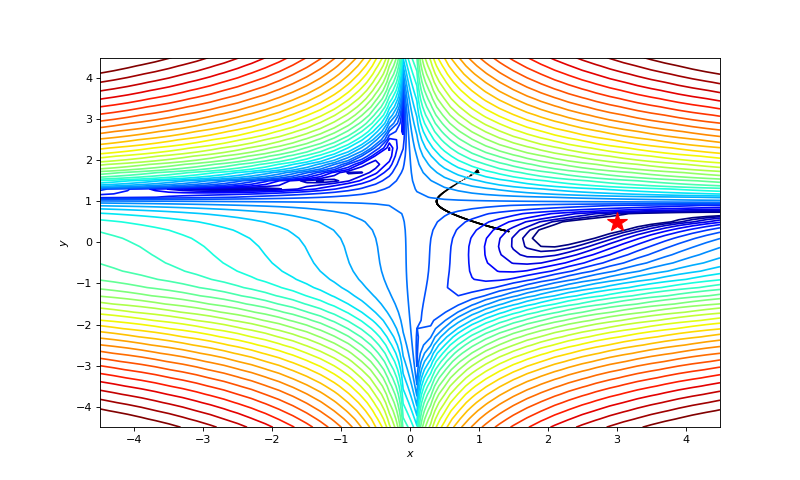

In [58]:
print(adagrad_diff)
trace_path(adagrad_sol)

<IPython.core.display.Javascript object>


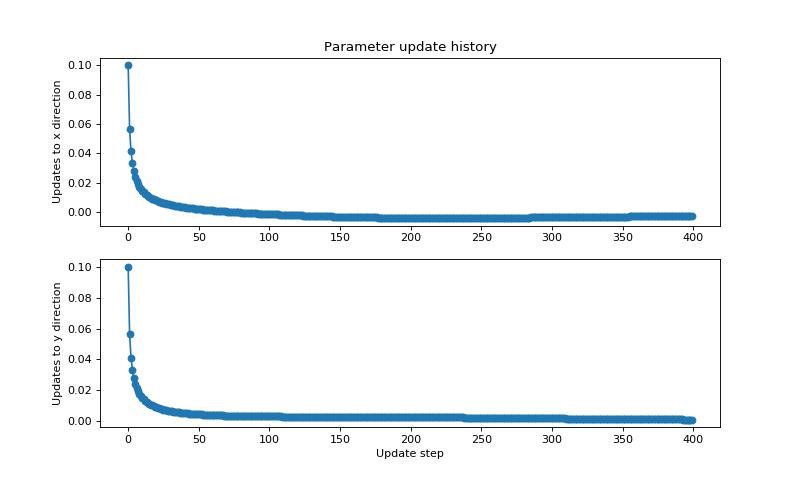

In [59]:
view_update_history(adagrad_updates)

**Adadelta**

In [60]:
def adadelta_beale(start=start_med, target=minimum, gamma=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    Etheta = np.zeros(start.shape[0])
    Eg = np.zeros(start.shape[0])
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        Eg = gamma * Eg + (1 - gamma) * (grad**2)
        RMSg = np.sqrt(Eg + eps)

        RMStheta = np.sqrt(Etheta + eps)
        delta_params = (RMStheta / RMSg) * grad

        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        Etheta = gamma * Etheta + (1 - gamma) * (delta_params**2)
 
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [61]:
adadelta_sol, adadelta_updates, adadelta_diff = adadelta_beale(start=start_med, epochs=400)

0.3303773602709788


<IPython.core.display.Javascript object>


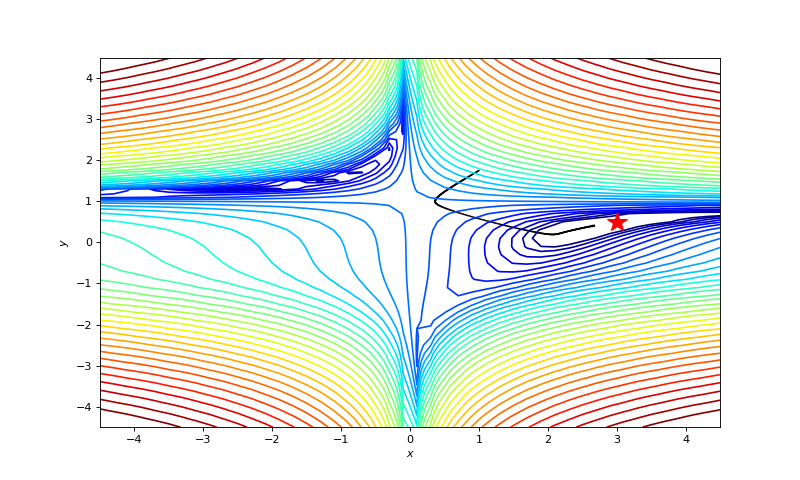

In [62]:
print(adadelta_diff)
trace_path(adadelta_sol)

<IPython.core.display.Javascript object>


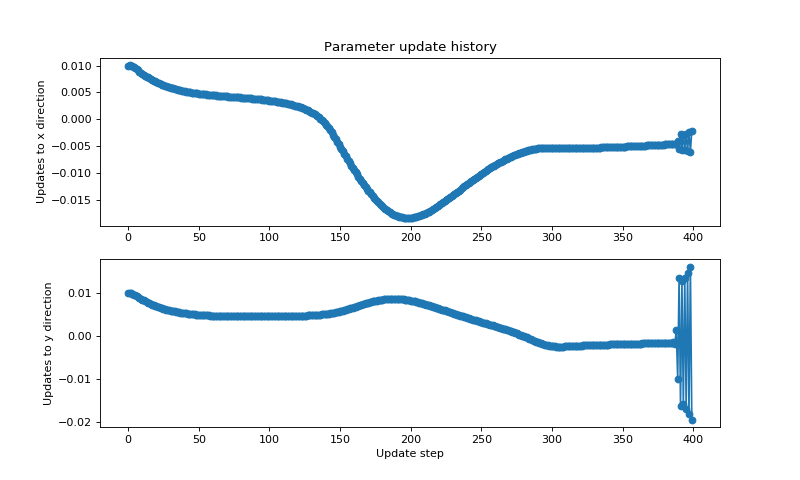

In [63]:
view_update_history(adadelta_updates)

**RMSProp**

In [64]:
def rmsprop_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    Eg = np.zeros(start.shape[0])
    #Eg = None
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        if Eg is None:
            Eg = grad**2
        else:
            Eg = gamma * Eg + (1 - gamma) * (grad**2)
        
        RMSg = np.sqrt(Eg + eps)
        
        delta_params = (lr / RMSg) * grad

        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [65]:
rmsprop_sol, rmsprop_updates, rmsprop_diff = rmsprop_beale(start=start_med, lr=1e-2, gamma=0.9, epochs=400)

0.09687844841688657


<IPython.core.display.Javascript object>


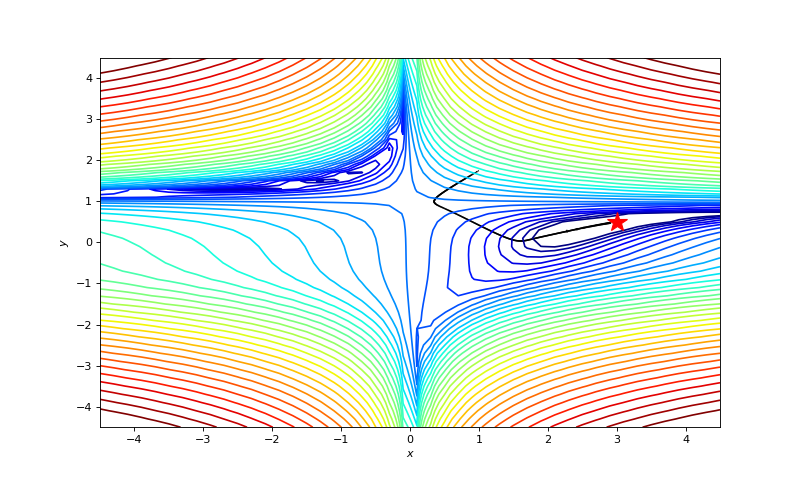

In [66]:
print(rmsprop_diff)
trace_path(rmsprop_sol)

<IPython.core.display.Javascript object>


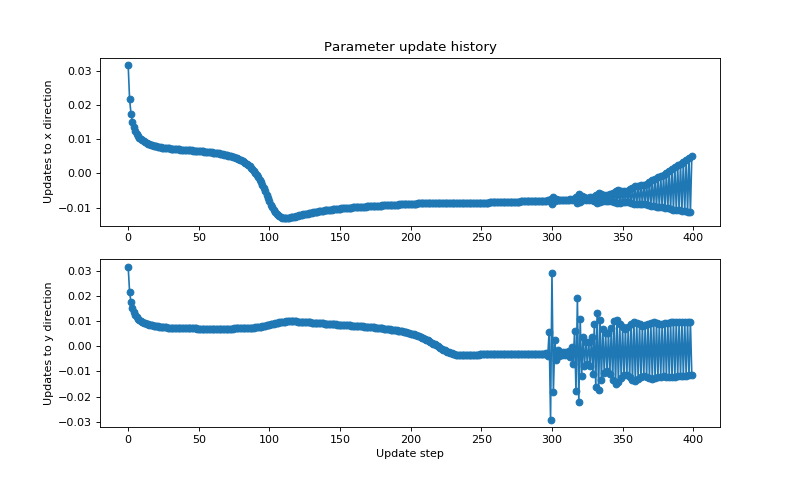

In [67]:
view_update_history(rmsprop_updates)

**Adam**

In [68]:
def adam_beale(start=start_med, target=minimum, lr=1e-3, beta1=0.9, beta2=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    params = start
    
    m = np.zeros(start.shape[0])
    v = np.zeros(start.shape[0])
    
    beta1_norm = 1.0
    beta2_norm = 1.0
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad**2)
        
        beta1_norm = beta1_norm * beta1
        beta2_norm = beta2_norm * beta2
        
        m_norm = m / (1 - beta1_norm)
        v_norm = v / (1 - beta2_norm)
        
        
        delta_params = (lr / (np.sqrt(v_norm) + eps)) * m_norm
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [69]:
adam_sol, adam_updates, adam_diff = adam_beale(start=start_med, lr = 1e-2, epochs=400)

0.03735099816997893


<IPython.core.display.Javascript object>


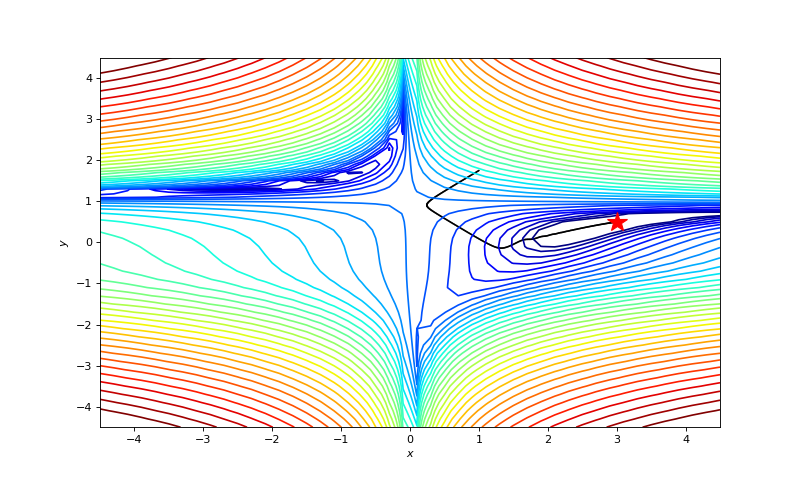

In [70]:
print(adam_diff)
trace_path(adam_sol)

<IPython.core.display.Javascript object>


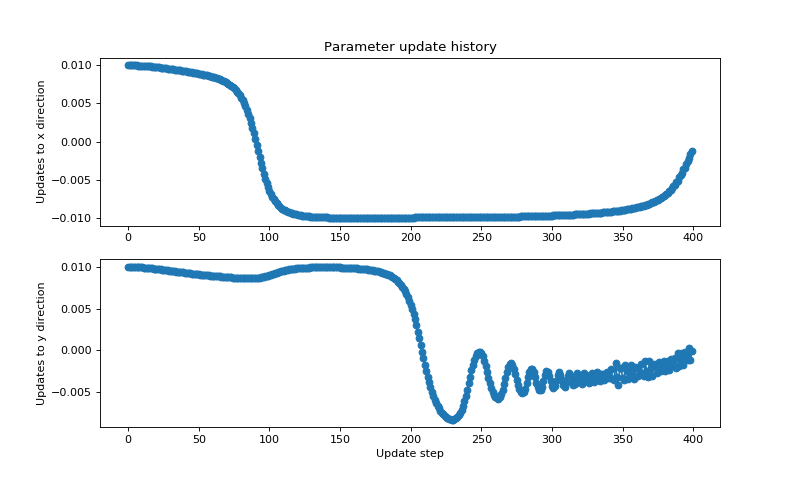

In [71]:
view_update_history(adam_updates)

## Comparative visualization

In [ ]:
METHODS = ['sgd', 'momentum', 'nesterov', 'adagrad', 'adadelta', 'rmsprop', 'adam']

class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, paths_dict, fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):
        
        self.paths_dict = paths_dict
        
        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.__set_paths_and_labels()

        if frames is None:
            frames = max(path.shape[1] for path in self.paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(self.paths, self.labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def __set_paths_and_labels(self):
        self.paths = []
        self.labels = []
        
        for m in METHODS:
            if m in self.paths_dict:
                self.labels.append(m)
                self.paths.append( np.array(self.paths_dict[m]).T )
        
    
    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points


def animate_paths(paths_dict):
    # define figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.plot(*minimum_t, 'r*', markersize=18)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    anim = TrajectoryAnimation(paths_dict, ax = ax)
    
    ax.legend(loc='upper left')

    return anim

In [ ]:
# define paths_dict
paths_dict = {
    'sgd': sgd_sol[::2],
    'momentum': momentum_sol[::5],
    'nesterov': nesterov_sol[::5],
    'adagrad': adagrad_sol[::5],
    'adadelta': adadelta_sol[::5],
    'rmsprop': rmsprop_sol[::5],
    'adam': adam_sol[::5]
}

anim = animate_paths(paths_dict)

HTML(anim.to_html5_video())